[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lrhgit/uqsa2025/blob/main/sensitivity_introduction_interactive_clean.ipynb)


In [17]:
# @title Install required packages (Colab)
variable_name = ""

!pip install --quiet --prefer-binary numpoly==1.3.8 chaospy==4.3.21

import numpoly, chaospy as cp
print("numpoly:", numpoly.__version__)
print("chaospy:", cp.__version__)


numpoly: 1.3.8
chaospy: 4.3.21


In [2]:
# @title Layout fix + imports

import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
HTML("""
<style>
div.cell.code_cell, div.output {
    max-width: 100% !important;
}
</style>
""")

import matplotlib.pyplot as plt
import numpy as np


In [3]:
# @title Repo sync and environment setup

import os, sys, subprocess

IN_COLAB = "google.colab" in sys.modules

REPO_PATH = "/content/uqsa2025"
REMOTE = "https://github.com/lrhgit/uqsa2025.git"

# Clone or update repository
if IN_COLAB:
    if not os.path.exists(REPO_PATH):
        subprocess.run(["git", "clone", REMOTE, REPO_PATH], check=True)
    else:
        %cd $REPO_PATH
        !git pull

# Add python_source to path
sys.path.insert(0, REPO_PATH + "/python_source")

print("Repo path:", REPO_PATH)


/content/uqsa2025
Already up to date.
Repo path: /content/uqsa2025


In [4]:
# @title Load project modules

import ipywidgets as widgets
from ipywidgets import VBox, HBox

# Helper modules from python_source/
from slider_helpers import build_slider_interface, make_slider_dict
from plotting import plot_sobol_indices
from monte_carlo import generate_sample_matrices_mc, calculate_sensitivity_indices_mc

# Conditional slices: reload to pick up GitHub updates
import importlib
import conditional_slices
importlib.reload(conditional_slices)
from conditional_slices import conditional_slices_interactive

print("✓ Project modules loaded")
print("Loaded conditional_slices from:", conditional_slices.__file__)


✓ Project modules loaded
Loaded conditional_slices from: /content/uqsa2025/python_source/conditional_slices.py


# Introduction <div id="sec:introduction"></div>

This practical introduction to
sensitivity analysis is based on the
presentation and examples available from
[saltelli_global_2008](#saltelli_global_2008). To give
the reader an even
better hands on experience of the topic, we have
integrated the computations in
a python notebook format.

Many sensitivity analyses reported in the literature
are based on
derivatives at set point or point of interest. Indeed such
approaches
are based on the fact that the derivative of $\partial Y_i/\partial
X_j$ of quantity of interest $Y_i$ as a function of an input variable
$X_j$ can
be thought of as the mathematical definition of the
sensitivity of $Y_i$ versus
$X_j$.

However, what is important to keep in mind is that local derivatives
are
only informative at the set point in the parameter space at which
they are
computed, and do not provide information for the rest of the
parameter space.
Naturally, such a linearisation will matter little
for linear models, but care must be
taken for general, nonlinear models.  This is especially important
in situations when the input
parameters are uncertain.

# Local versus global sensitivity analysis

Motivation and useful purposes of sensitivity analysis

* Parameter prioritization of parameters of high sensitivity (importance)

* Parameter fixation of parameters of low sensitivity (importance)

* Reveal surprising relations/properties of the model

* Identify critical regions in the input parameter space

## Local approaches based on derivatives

Many
sensitivity analyses found in the scientific literature are based
on
derivatives.  This fact has naturally a rational basis as the
partial derivative
$\partial y/\partial Z_i$ of a model prediction $y$
with respect to an input
$Z_i$, can be understood as the mathematical
representation of the sensitivity
of $y$ with respect to $Z_i$.

Although a local, partial derivative approach
is computationally
inexpensive, it has in general limited usage for nonlinear
models. The
derivatives are linearizations of the model sensitivities around the
point in the parameter space at which they are evaluated, and may only
be
extrapolated to provide information on the sensitivity in other
regions of the
parameter space in the case of a linear model.

To illustrate the fraction of
the parameter space one may
explore with the local partial
derivative approach (also called the
one factor at the time (OAT) approach), we
provide a code snippet which
calculates the ratio of a
[hypersphere](https://en.wikipedia.org/wiki/N-sphere#Recurrences) to a
hypercube.

In [5]:
from python_source.hypercube_demo import hypercube_demo
hypercube_demo()


Based on the brief motivation above, we will present of
methods basedon the exploration of the input parameter space by judiciously
selecting samples in that space. Such approaches result in more robust and
informative sensitivity measures than a local
derivative approach at the center of the parameter space.

To introduce themethods of sensitivity analysis, we shall
start from derivatives and illustrate
them on a very simple linear model.

# A simple linear model

As an simple linear model example consider:

<!-- Equation labels as ordinary links -->
<div id="eq:linear_model"></div>
$$
Y = \sum_{i=1}^{r} \Omega_i \, Z_i
\tag{1}
$$
where the input factors are $\mathbf{X} = (\Omega_1, \Omega_2, \ldots,
\Omega_r,
Z_1, Z_2, \ldots, Z_r)$. For simplicity we assume that the
model output $Y$ of
([1](#eq:linear_model)) is a scalar and
that the $\Omega s$ are fixed
coefficients or weights.

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>
$$
 \Omega_1=\Omega_2=\ldots=\text{constant}
\tag{2}
$$
Consequently, the true factors of ([1](#eq:linear_model)) are just
$(Z_1, Z_2,
\ldots, Z_r)$. The individual variables
$Z_i$ are taken as normally distributed
with mean zero

<!-- Equation labels as ordinary links -->
<div id="eq:NZi"></div>
$$
 Z_i \sim N(0, \sigma_{Z_i}), \qquad i=1,2, \ldots, r
 \tag{3}
$$
As the predicted value $Y$ of the model in ([1](#eq:linear_model)) is
linear
combination of normally distributed factors, it is easy to
verify (see exercices
in [saltelli_global_2008](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470725184) that $Y$ also will
be
normally distributed with:

<!-- Equation labels as ordinary links -->
<div id="eq:analytic_mean_std"></div>
$$
\bar{y} = \sum_{i=1}^{r} \Omega_i \; \bar{z}_i, \qquad
\sigma_Y = \sqrt{\sum_{i=1}^{r} \Omega_i^2 \, \sigma_{Z_i}^2}
 \tag{4}
$$
Furthermore, we order the factors from the most certain to the less
certain,
i.e.:

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>
$$
 \sigma_{Z_1} <  \sigma_{Z_2} <  \ldots  <  \sigma_{Z_r}
 \tag{5}
$$

# Scatterplots versus derivatives

We have implemented the simple linear model
in ([1](#eq:linear_model)) in python as:

In [6]:
# @title
from linear_model import linear_model

# Showing the code to the student
import inspect
print(inspect.getsource(linear_model))


def linear_model(w, z):
    """
    Linear model used across the entire notebook:
        Y = sum_i (w_i * z_i)

    Parameters
    ----------
    w : array-like, shape (Nrv,)
        Weights for each random variable.

    z : array-like, shape (Ns, Nrv)
        Sample matrix where rows are samples and columns correspond to random variables.

    Returns
    -------
    Y : array-like, shape (Ns,)
        Model outputs for each sample.
    """
    return np.sum(w * z, axis=1)



To hold the mean and the standard deviation of all the input factors
we use a
numpy-array of size $r\times 2$, with one row per factor,
where the first column
holds the mean whereas the second column holds
the standard deviation. The
weights $\Omega_{1\ldots r}$ are stored in a numpy-vector.

In [7]:
# Set mean (column 0) and standard deviations (column 1) for each factor z. Nrv=nr. rows
Nrv = 4  # number of random variables
zm = np.array([[0., i] for i in range(1, Nrv + 1)])

    # The above "list comprehension" is equivalent to the next for lines
    # zm = np.zeros((Nrv, 2))
    # zm[0, 1] = 1
    # zm[1, 1] = 2
    # zm[2, 1] = 3
    # zm[3, 1] = 4

# Set the weights
c = 2
w = np.ones(Nrv) * c

We may now perform a Monte Carlo experiment on our model by generating $N$
samples from the distributions of each factor and an input sample is thus
produced:

<!-- Equation labels as ordinary links -->
<div id="eq:mc_sample"></div>
$$
\mathbf{Z} = \left [
\begin{array}{cccc}
Z_{1,1} & Z_{1,2}  &
\ldots & Z_{1,N} \\
Z_{2,1} & Z_{2,2}  & \ldots & Z_{2,N}\\
\vdots & \vdots &
\vdots & \vdots \\
Z_{r,1} & Z_{r,2}  & \ldots & Z_{r,N}
\end{array}
\right ]
 \tag{6}
$$
We may the compute a value of $Y$ from ([1](#eq:linear_model)) for each
column
in ([6](#eq:mc_sample)) to produce a solution vector
$\mathbf{Y}$. Having
sampled $N$ values from each input factor we may
produce $r$ scatter plots, by
projecting in turn the $N$ values of
$\mathbf{Y}$ against the $N$ values of each
of the $r$ input factors.

<!-- Equation labels as ordinary links -->
<div id="eq:mc_solution"></div>
$$
\mathbf{Y} = \left [
\begin{array}{c}
y_1 \\
y_2 \\
\vdots \\
y_N
\end{array}
\right ]
 \tag{7}
$$

In [8]:
# Generate distributions for each element in z and sample
Ns = 500

# jpdf = generate_distributions(zm)

pdfs = []

for i, z in enumerate(zm):
    pdfs.append(cp.Normal(z[0], z[1]))

jpdf = cp.J(*pdfs)

# generate Z
Z = jpdf.sample(Ns)
# evaluate the model
Y = linear_model(w, Z.transpose())

Note that the assumption of independent factors $Z_i$ allows us to sample
each
$Z_i$ independently from its own marginal distribution. We store
all the samples
for all the factors $Z_i$ in the the numpy array
`Z[i,:]`, where $i$ corresponds
to $Z_i$ as:

pdf.append(cp.Normal(z[0],z[1]))
Z[i,:]=pdf[i].sample(N)

From the scatterplots generated by the python code above we
intuitively get the
impression that $Y$ is more sensitive to $Z_4$
than to $Z_3$, and that $Y$ is
more sensitive to $Z_3$ than to $Z_3$,
and that we may order the factors my
influence on $Y$ as:

<!-- Equation labels as ordinary links -->
<div id="eq:scatter_plot_rank"></div>
$$
Z_4 > Z_3 > Z_2 > Z_1
 \tag{8}
$$
Our intuitive notion of influence is based on that there is more shape
(or
better pattern) in the plot for $Z_4$ than for $Z_3$ and likewise.

For our
simple linear model in ([1](#eq:linear_model)) we are in the
fortunate situation
that we may compute the local derivatives analyticaly:

<!-- Equation labels as ordinary links -->
<div id="eq:Sp"></div>
$$
S_{Z_i}^{p} = \frac{\partial Y}{\partial Z_i} = \Omega_i
 \tag{9}
$$
In our code example we set all the $\Omega_i=2$ for $i=1,\ldots,4$,
and
according to the local sensitivity measure $S_{Z_i}^{p}$ in
([9](#eq:Sp)) all
the input factors $Z_i$s are equally important and
independent of the variation
of each factor. This measure is clearly
at odds with the ranking of influence
based on the scatterplots in
([8](#eq:scatter_plot_rank)) and is an indication
of the usefulness of
scatterplots in sensitivy analysis. However, the
bidimensional
scatterplots may in some cases be deceiving and lead to type II
errors (i.e. failure to identify influential parameters) [Saltelli et al. 2004](https://www.wiley.com/en-us/Sensitivity+Analysis+in+Practice%3A+A+Guide+to+Assessing+Scientific+Models-p-9780470870938)

Most sensitivity measures aim to preserve the rich information
provided
by the scatterplots in a condensed format. The challenge is
how to rank the
factors rapidly and automatically without having to
inspect many scatterplots in
situations with many input
factors. Another challenge with scatterplots is that
sensitivities for
sets cannot be visualized, while luckily compact sensitivity
measures may be
defined in such cases.

In [9]:
# Interactive scatterplot demo for the linear model
from scatter_demo import scatter_demo

scatter_ui = scatter_demo(Z)
display(scatter_ui)


# Normalized derivatives

A simple way to improve the derivative sensitivity
measure $S_{Z_i}^{p}$ in
([9](#eq:Sp)) is to scale the input-output variables
with their standard deviations:

<!-- Equation labels as ordinary links -->
<div id="eq:Ss"></div>
$$
S_{Z_i}^{\sigma} = \frac{\partial Y/\sigma_Y}{\partial
Z_i/\sigma_{Z_i}} = \frac{\sigma_{Z_i}}{\sigma_{Y}} \; \frac{\partial
Y}{\partial Z_i}
 \tag{10}
$$
In case of our simple linear model ([1](#eq:linear_model)) we get from
([10](#eq:Ss)):

<!-- Equation labels as ordinary links -->
<div id="eq:Ss_simple"></div>
$$
\left (S_{Z_i}^{\sigma} \right)^2 = \left(
\frac{\sigma_{Z_i}}{\sigma_{Y}}\right)^2 \; \left (\frac{\partial Y}{\partial
Z_i}\right)^2 = \left( \frac{\sigma_{Z_i}\, \Omega_i}{\sigma_{Y}}\right)^2 \;
\qquad \textsf{which may be rearranged to:} \qquad \sigma_y^2 \,
(S_{Z_i}^{\sigma})^2 = \left ( \Omega_{i} \sigma_{Y} \right )^2
 \tag{11}
$$
Based on the linearity of our model we previously found
([4](#eq:analytic_mean_std)) which also yields:

<!-- Equation labels as ordinary links -->
<div id="eq:Ss_model_ded"></div>
$$
 \sigma_Y^2 = \sum_{i=1}^{r} \left(\Omega_i^2 \,
\sigma_{Z_i}\right)^2
 \tag{12}
$$
As both ([12](#eq:Ss_model_ded)) and ([11](#eq:Ss_simple)) must hold
simultaneously we get

<!-- Equation labels as ordinary links -->
<div id="eq:Ss1"></div>
$$
\left (S_{Z_i}^{\sigma} \right)^2=1
 \tag{13}
$$
The normalized derivative measure of sensitivity in ([10](#eq:Ss)) is
more
convincing than ([9](#eq:Sp)): first, as it involves both the
weights $\Omega_i$
and the factors $Z_i$ in ([1](#eq:linear_model));
second as the measures are
properly scaled and sums up to one,
which allows for an easy interpretation
of the output sensitivity with
respect to each of the input factors.

In [10]:
# Theoretical sensitivity indices
std_y = np.sqrt(np.sum((w * zm[:, 1])**2))
s = w * zm[:,1]/std_y

import pandas as pd
print("\nTheoretical sensitivity indices\n")
row_labels= ['S_'+str(idx) for idx in range(1,Nrv+1)]
print(pd.DataFrame(s**2, columns=['S analytic'],index=row_labels).round(3))


Theoretical sensitivity indices

     S analytic
S_1       0.033
S_2       0.133
S_3       0.300
S_4       0.533


Based on samples of the random input variables and subsequent model
evaluations, we may estimate the standard deviation
of $\mathbf{Y}$ and compute
the relative error with respect to the
theoretical value. You may change the
number of sample above,
i.e. $N$, and see how $N$ influence the estimates.

In [11]:
#  Expectation and variance from sampled values

print("Expectation and std from sampled values\n")
print('std(Y)={:2.3f} and relative error={:2.3f}'.format(np.std(Y, 0), (np.std(Y, 0) - std_y) / std_y))
print('mean(Y)={:2.3f} and E(Y)={:2.3}'.format(np.mean(Y, 0), np.sum(zm[:,0]*w)))

Expectation and std from sampled values

std(Y)=10.319 and relative error=-0.058
mean(Y)=-0.400 and E(Y)=0.0


Note that `Ns` is the size of our Monte Carlo experiment, corresponding
to the
number of times we have evaluated our simple linear model
([1](#eq:linear_model)). The evaluation of the model is normally the
most
computationally expensive part of the analysis, and for that
reasons `Ns` is
referred to as the `cost` of the analysis.

# Conditional variances

As noted
previously, the importance of a factor $Z_i$ is manifested
the existence of a
`shape` or `pattern` in the scatter plot of model outputs
$Y$ against $Z_i$. Conversely, a uniform cloud of
output points $Y$ as a function of
$Z_i$ is a symptom - not a proof -
indicating that $Z_i$ is a
noninfluential factor. In this section we seek to
demonstrate that
conditional variances is a useful means to quantify the
`shape` or
`pattern` in the outputs.

The shape in the outputs $Y$ for a given
$Z_i$, may be seen in the
scatterplot as of $Y$ versus $Z_i$. In particular, we
may cut the
$Z_i$-axis into slices and assess how the distribution of the
outputs
$Y$ changes from slice to slice. This is illustrated in the code
snippet
below, where the slices are identified with vertical dashed
lines at equidistant
locations on each $Z_i$-axis, $i=1, \ldots,4$.

In [12]:

ui = conditional_slices_interactive(zm, w, jpdf)
ui


Note, that average value of $Y$ in a very thin slice, corresponds to
keeping $Z_i$ fixed while averaging over all output values of $Y$ due
to all-but $Z_i$,
which corresponds to the conditional expected value:

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>
$$
E_{Z_{\sim i}} (Y\;|\;Z_i)
 \tag{14}
$$
For convenience we let $Z_{\sim i}$ denote `all-but` $Z_i$. Naturally,
a measure
of how much $E_{Z_{\sim i}} (Y\;|\;Z_i)$ varies in the range
of $Z_i$ is given
by the conditional variance:

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>
$$
\text{V}_{Z_i}(E_{Z_{\sim i}} (Y\;|\;Z_i))
\tag{15}
$$
Further, the variance the output $Y$ may be decomposed into:

<!-- Equation labels as ordinary links -->
<div id="eq:VarDecomp"></div>
$$
\text{V}(Y) = E_{Z_i} ( V_{Z_{\sim i}} (Y \; | Z_{i})) +
\text{V}_{Z_i}(E_{Z_{\sim i}} (Y\;|\;Z_i))
 \tag{16}
$$
A large $\text{V}_{Z_i}(E_{Z_{\sim i}} (Y\;|\;Z_i))$ will imply that
$Z_i$ is an
important factor and is therefore coined the first-order
effect of $Z_i$ on $Y$,
and its fraction of the total variation of $Y$ is expressed by $S_i$, `the
first-order sensitivity index` of $Z_i$ on $Y$:

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>
$$
S_i = \frac{\text{V}_{Z_i}(E_{Z_{\sim i}}
(Y\;|\;Z_i))}{\text{V}(Y)}
 \tag{17}
$$
By ([16](#eq:VarDecomp)), $S_i$ is number always in the range $[0,1]$,
and a
high value implies an important factor.

# How to compute the sensitivity indices

Below we will demostrate how the Sobol
sensitivity indices may be
computed with two approaches; the Monte Carlo method
and the
polynomial chaos expansion method.

### Monte Carlo

Below some code
snippets are provided to illustrate how we may compute
the Sobol indices with
the MCM. For the interested reader we have also
written a seperate and more
detailed notebook [A brief introduction to
UQ and SA with the Monte Carlo
method](monte_carlo.ipynb).

In [13]:
# calculate sens indices of non additive model
def mc_sensitivity_linear(Ns, jpdf, w, sample_method='R'):

    Nrv = len(jpdf)

    # 1. Generate sample matrices
    A, B, C = generate_sample_matrices_mc(Ns, Nrv, jpdf, sample_method)

    # 2. Evaluate the model
    Y_A, Y_B, Y_C = evaluate_linear_model(A, B, C, w)

    # 3. Approximate the sensitivity indices
    S, ST = calculate_sensitivity_indices_mc(Y_A, Y_B, Y_C)

    return A, B, C, Y_A, Y_B, Y_C, S, ST
# end calculate sens indices of non additive model


# model evaluation
def evaluate_linear_model(A, B, C, w):

    number_of_parameters = A.shape[1]
    number_of_sampless = A.shape[0]
    # 1. evaluate sample matrices A
    Y_A = linear_model(w, A)

    # 2. evaluate sample matrices B
    Y_B = linear_model(w, B)

    # 3. evaluate sample matrices C
    Y_C = np.empty((number_of_sampless, number_of_parameters))
    for i in range(number_of_parameters):
        z = C[i, :, :]
        Y_C[:, i] = linear_model(w, z)

    return Y_A, Y_B, Y_C

In [14]:
# Monte Carlo
# get joint distributions

from sensitivity_examples_nonlinear import generate_distributions

jpdf = generate_distributions(zm)

Ns_mc = 1000000
# calculate sensitivity indices
A_s, B_s, C_s, f_A, f_B, f_C, S_mc, ST_mc = mc_sensitivity_linear(Ns_mc, jpdf, w)

Sensitivities=np.column_stack((S_mc,s**2))
row_labels= ['S_'+str(idx) for idx in range(1,Nrv+1)]
print("First Order Indices")
print(pd.DataFrame(Sensitivities,columns=['Smc','Sa'],index=row_labels).round(3))


First Order Indices
       Smc     Sa
S_1  0.034  0.033
S_2  0.133  0.133
S_3  0.300  0.300
S_4  0.532  0.533


### Polynomial chaos expansion

As for the MCM some code snippets are provided
to illustrate how we may compute
the Soboil indices with the polynomial chaos
expansions using `chaospy`. A more in-depth view on `chaospy` and its usage
can be found in the notebook [A practical introduction to polynomial
chaos with the chaospy package](introduction_gpc.ipynb).

In [16]:
# --- Polynomial chaos (recommended: stieltjes) ---

# Use same jpdf and linear model setup (zm, w, jpdf)

Ns_pc = 100
samples_pc = jpdf.sample(Ns_pc)

Y_pc = linear_model(w, samples_pc.T)

# Recommended basis construction
order = 4
poly = cp.expansion.stieltjes(order, jpdf)

# Regression-based fit
approx = cp.fit_regression(poly, samples_pc, Y_pc)

# Statistics
exp_pc = float(cp.E(approx, jpdf))
std_pc = float(cp.Std(approx, jpdf))

print("PCE statistics:")
print("E(Y) =", exp_pc)
print("Std(Y) =", std_pc)

# Sobol indices
S_pc = cp.Sens_m(approx, jpdf)

row_labels = [f"S{i+1}" for i in range(len(zm))]

print("\nFirst-order indices (PCE vs analytic):\n")
print(pd.DataFrame(
    np.column_stack([S_pc, s**2]),
    columns=["Spc", "Sa"],
    index=row_labels
).round(3))


PCE statistics:
E(Y) = 5.249333953284234e-13
Std(Y) = 10.95445115010363

First-order indices (PCE vs analytic):

      Spc     Sa
S1  0.033  0.033
S2  0.133  0.133
S3  0.300  0.300
S4  0.533  0.533


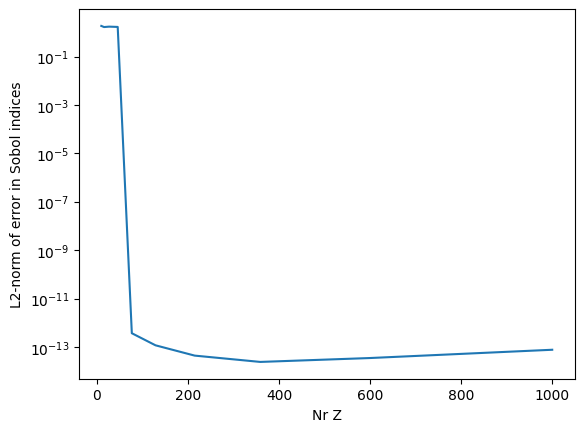

In [20]:
# Polychaos convergence
from numpy import linalg as LA
Npc_list = np.logspace(1, 3, 10).astype(int)
error = []

for i, Npc in enumerate(Npc_list):
    Zpc = jpdf.sample(Npc)
    Ypc = linear_model(w, Zpc.T)
    Npol = 4
    poly = cp.expansion.cholesky(Npol, jpdf)
    approx = cp.fit_regression(poly, Zpc, Ypc)
    s_pc = cp.Sens_m(approx, jpdf)
    error.append(LA.norm((s_pc - s**2)/s**2))

plt.figure()
plt.semilogy(Npc_list, error)
_=plt.xlabel('Nr Z')
_=plt.ylabel('L2-norm of error in Sobol indices')
